In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.collections import LineCollection
from ast import literal_eval as make_tuple
from math import exp
import random


%matplotlib inline



In [7]:
########## Functions for Coalescent figures ##########

def make_lattice_points(x,y):
    """Return a flat array of all lattice points that fill between the origin and (x,y)

    Defines the initial set of points that we will use to simulate the coalescent process
    """
    lattice_points = []
    for x in range(0, x+1):
        for y in range(0, y+1):
            point = (x,y)
            lattice_points.append(point)
    return lattice_points


def plot_lattice_points(points, **kwargs):
    """Plot a flattened array of lattice points"""
    xs = [point[0] for point in points]
    ys = [point[1] for point in points]
    plt.scatter(xs, ys, **kwargs)


def plot_generation_points(generations, ax, **kwargs):
    """Plot the lattice points (may be truncated) that are in generation form
    
    This is the function we will actually use to plot points

    Basically does what plot_lattice_points does but does some flattening first
    """
    pts = []
    for gen in generations:
        for pt in gen:
            pts.append(pt)
    xs = [point[0] for point in pts]
    ys = [point[1] for point in pts]
    ax.scatter(xs, ys, **kwargs)


def make_generations(points):
    """Transform the points into discrete-time generations"""
    generations = [ [] for i in range(points[-1][0] + 1)]
    for point in points:
        gen = point[0]
        generations[gen].append(point)
    return generations


def simulate_coalescent(generations):
    """Simulate the coalescent process on a list of generations"""
    segs = []
    # iterate backwards through the generations
    for gen in reversed(generations):
        gen_idx = gen[0][0]
        if gen_idx == 0:
            break
        # each point chooses its ancestor uniformly at random from the previous generation
        # ancestors are just keyed by their y value
        for p in gen:
            anc_idx = np.random.randint(0, len(generations[gen_idx - 1]))  # choose a random ancestor
            ancestor = (gen_idx - 1, anc_idx)
            # add the line segment from the ancestor to the current point to the list
            segs.append((ancestor, p))
    segs.reverse()
    segs.sort() # because we iterated backwards we need to reverse the list
    return segs


def untangle_coalescent(segs, generations):
    """Untangle the coalescent segments so that they can be plotted nicely
    
    eliminates crossing lines and returns a new list of line segments that have been sorted out
    """
    point_dict = {}
    for i in range(len(segs)): # iterate through generations
        if str(segs[i][0]) not in point_dict:
            # we cheat not being able to use tuples as keys by using a string
            point_dict[str(segs[i][0])] = [segs[i][1]]
        else:
            point_dict[str(segs[i][0])].append(segs[i][1]) 
    # Sort the list of points for each connection
    for k,v in point_dict.items():
        point_dict[k] = sorted(v, key=lambda x: x[1])

    # Now we sort
    sorted_segs = []
    for i in range(len(generations)-1):
        c = 0 # set the values to this number
        for k, v in point_dict.items():
            from_pt = make_tuple(k)
            if from_pt[0] == i:
                for val in v:
                    to_pt = (i+1, c)
                    sorted_segs.append((from_pt, to_pt))
                    c += 1
    
    return sorted_segs


def sample_from_coalescent(segs, generations, n):
    """Sample n points from the coalescent process and returns the history that connects them
    """
    new_segs = []
    new_gens = []

    sample = random.sample(range(len(generations[-1])), n)
    for gen in reversed(range(1, len(generations))): # gen gives the generation index
        new_sample = []
        new_gen = []
        for seg in segs:
            if (seg[1][1] in sample) and (seg[1][0] == gen):
                new_segs.append(seg) # add the ingoing segment to the new list
                new_sample.append(seg[0][1]) # update the sample list that we will push through to the next generation
                new_gen.append(seg[1]) # add the current y coordinate to the updated generation
        new_gens.append(new_gen)
        sample = list(set(new_sample))

    # Now we have to catch the edge case that the first generation is not added to the grid point list:
    new_gen = []
    for seg in segs:
        if (seg[0][0] == 0) and (seg[1] in new_gens[-1]):
            new_gen.append(seg[0])
    new_gens.append(new_gen)

    new_gens.reverse()
    return new_segs, new_gens


def shift_points(generations, sampled_points):
    """Center everything about the x axis"""
    new_gens = []
    shifts = []
    for gen in generations:
        shift = (len(gen) - 1) / 2
        new_gen = []
        for pt in gen:
            new_gen.append((pt[0], pt[1] - shift))
        new_gens.append(new_gen)
        shifts.append(shift)
    
    #TODO also shift the sampled points
    new_pts = []
    assert len(sampled_points) == len(shifts), "The number of sampled points and the number of shifts do not match"
    for i in range(len(sampled_points)):
        new_gen = []
        for pt in sampled_points[i]:
            new_gen.append((pt[0], pt[1] - shifts[i]))
        new_pts.append(new_gen)

    return new_gens, new_pts, shifts


def shift_lines(lines, shifts):
    """Center everything about the x axis"""
    new_lines = []
    for line in lines:
        new_lines.append(((line[0][0], line[0][1]-shifts[line[0][0]]), (line[1][0], line[1][1]-shifts[line[1][0]])))
    return new_lines


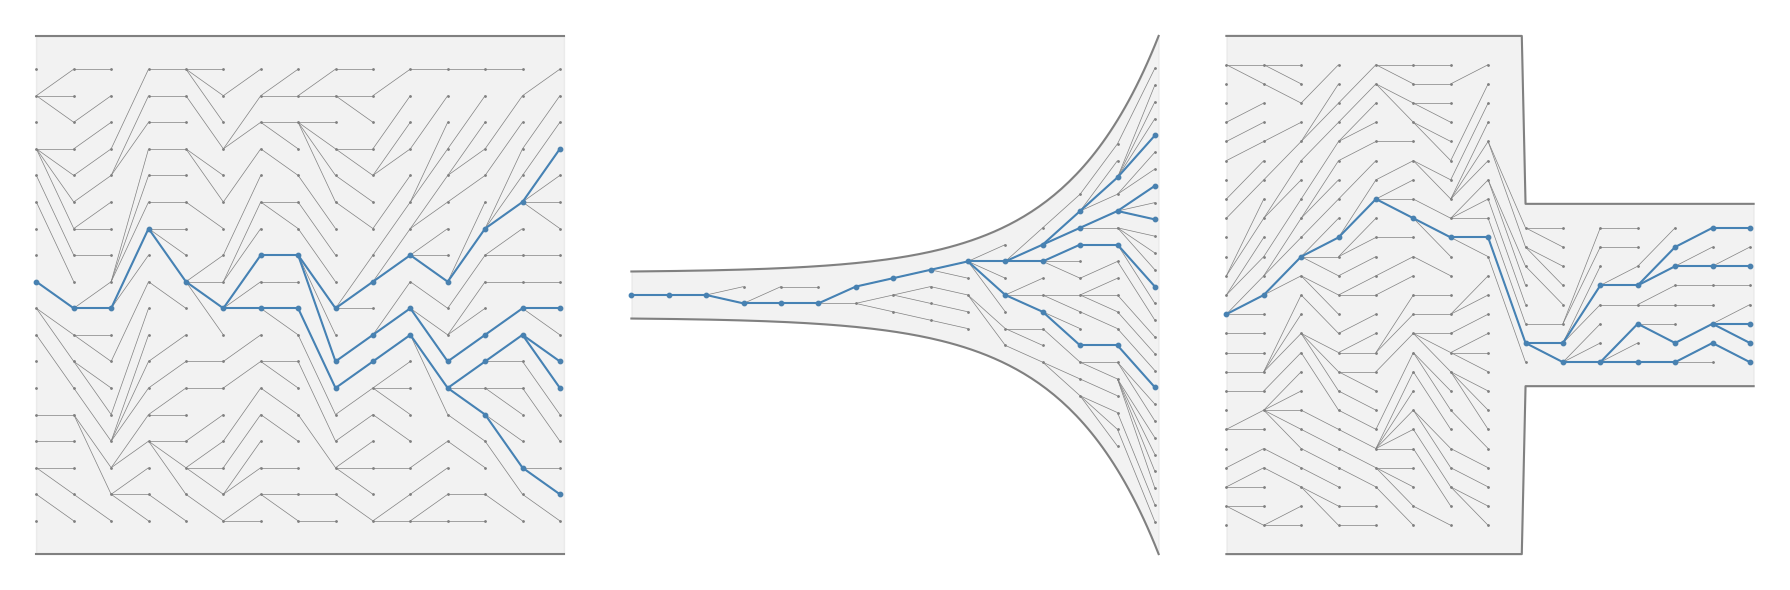

In [9]:

def plot_coalescent(n_generations, population_size, limiting_function, ax, bcolor='gray', bsize=1, scolor='steelblue', ssize=10, n=7):
    # make the lattice points
    lpoints = make_lattice_points(n_generations-1, population_size-1) # deal with an off by one error
    # truncate by the limiting function
    lpoints = [item for item in lpoints if item[1] < limiting_function(item[0])]
    # convert the truncated lattice points into points for each generation
    gen_pts = make_generations(lpoints)
    # simulate the coalescent process and untangle the segments
    coal_segs = simulate_coalescent(gen_pts)
    sorted_segs = untangle_coalescent(coal_segs, gen_pts)
    # sample a subset to highlight
    (sampled_coalescent, sampled_points) = sample_from_coalescent(sorted_segs, gen_pts, n)

    # shift the points and lines so that they are centered about the x axis
    (new_gens, new_sample, shifts) = shift_points(gen_pts, sampled_points)
    new_lines = shift_lines(sorted_segs, shifts)
    new_sampled_lines = shift_lines(sampled_coalescent, shifts)

    # plot all the stuff we just did
    line_segments = LineCollection(new_lines, color=bcolor, lw=bsize/2, zorder = 1) # background line segments
    ax.add_collection(line_segments)
    plot_generation_points(new_gens, ax, color=bcolor, s=1, zorder=1) # background lattice points

    line_segments = LineCollection(new_sampled_lines, color=scolor) # sampled (foreground) line segments
    ax.add_collection(line_segments)
    plot_generation_points(new_sample, ax, color=scolor, s=ssize) # sampled (foreground) lattice points
    
    # now plot the limiting function over top
    t = np.arange(0, n_generations-.8, 0.1)
    y1 = list(map(lambda x: (x/2) +1, map(limiting_function, t)))
    y2 = list(map(lambda x: (-x/2) -1, map(limiting_function, t)))
    ax.plot(t, y1, color=bcolor) 
    ax.plot(t, y2, color=bcolor)

    ax.fill_between(t, y1, y2, color=bcolor, alpha=0.1)

    ax.axis('off')
    return new_sampled_lines

n_generations = 20
population_size = 25
n = 5

limiting_function_1 = lambda x: 0.7*population_size
limiting_function_2 = lambda x: 0.1*exp(x*0.4) + .7
limiting_function_3 = lambda x: population_size if x < (0.4*n_generations) else 0.3*population_size

fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharex=True, sharey=False, figsize=(18,6))
np.random.seed(111)
l1 = plot_coalescent(15, 35, limiting_function_1, ax=ax1, n=n)
np.random.seed(666)
l2 = plot_coalescent(15, 35, limiting_function_2, ax=ax2, n=n)
l3f = plot_coalescent(15, 35, limiting_function_3, ax=ax3, n=n)
plt.tight_layout()
plt.show()

In [30]:
class treeSegment():
    def __init__(self, x, y, children=[]):
        self.x = x
        self.y = y
        self.children = children

    def __repr__(self):
        return f"treeSegment({self.x},{self.y})"
    
    def __eq__(self, other):
        if not isinstance(other, treeSegment):
            return NotImplemented
        return self.x == other.x and self.y == other.y

    def __hash__(self):
        return hash((self.x, self.y))

all_treeSegments = []

for line in reversed(l1):
    end = treeSegment(line[1][0], line[1][1])
    start = treeSegment(line[0][0], line[0][1], children=[end])
    if start not in all_treeSegments:
        all_treeSegments.append(start)
    else:
        start = all_treeSegments[all_treeSegments.index(start)]
        start.children.append(end)

treeSegment(0,0.5) [treeSegment(1,-0.5)]
treeSegment(1,-0.5) [treeSegment(2,-0.5)]
treeSegment(2,-0.5) [treeSegment(3,2.5)]
treeSegment(3,2.5) [treeSegment(4,0.5)]
treeSegment(4,0.5) [treeSegment(5,-0.5)]
treeSegment(5,-0.5) [treeSegment(6,1.5), treeSegment(6,-0.5)]
treeSegment(6,1.5) [treeSegment(7,1.5)]
treeSegment(6,-0.5) [treeSegment(7,-0.5)]
treeSegment(7,1.5) [treeSegment(8,-0.5), treeSegment(8,-2.5)]
treeSegment(7,-0.5) [treeSegment(8,-3.5)]
treeSegment(8,-0.5) [treeSegment(9,0.5)]
treeSegment(8,-2.5) [treeSegment(9,-1.5)]
treeSegment(8,-3.5) [treeSegment(9,-2.5)]
treeSegment(9,0.5) [treeSegment(10,1.5)]
treeSegment(9,-1.5) [treeSegment(10,-0.5)]
treeSegment(9,-2.5) [treeSegment(10,-1.5)]
treeSegment(10,1.5) [treeSegment(11,0.5)]
treeSegment(10,-0.5) [treeSegment(11,-2.5)]
treeSegment(10,-1.5) [treeSegment(11,-3.5)]
treeSegment(11,0.5) [treeSegment(12,2.5)]
treeSegment(11,-2.5) [treeSegment(12,-1.5)]
treeSegment(11,-3.5) [treeSegment(12,-2.5), treeSegment(12,-4.5)]
treeSegment(1